# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
    !mkdir tables

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf

## The Pmf class

I'll start by making a Pmf that represents the outcome of a coin toss.

In [4]:
coin = Pmf()
coin['heads'] = 1/2
coin['tails'] = 1/2
coin

,probs
heads,0.5
tails,0.5


This Pmf contains two values, each with probability 1/2.

Here's a Pmf that represents the outcome of a 6-sided die.

In [5]:
die = Pmf()
for x in [1,2,3,4,5,6]:
    die[x] = 1
    
die

,probs
1,1
2,1
3,1
4,1
5,1
6,1


Initially, the probabilities don't add up to 1 (so they are not really probabilities).

In [6]:
die.sum()

6

`normalize` divides the probabilities by their total, so they add up to 1.

In [7]:
die.normalize()

6

The return value from `normalize` is the sum of the probabilities before normalizing.

Now we can see that the total is 1 (at least within floating-point error).

In [8]:
die

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


In [9]:
die.sum()

0.9999999999999999

Another way make a Pmf is to provide a sequence of values.

In this example, every value appears once, so they all have the same probability.

In [10]:
die = Pmf.from_seq([1,2,3,4,5,6])
die

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


More generally, values can appear more than once.

In [11]:
letters = Pmf.from_seq(list('Mississippi'))
letters

,probs
M,0.090909
i,0.363636
p,0.181818
s,0.363636


In [12]:
from utils import write_pmf
    
write_pmf(letters, 'table02-01')

In [13]:
!cat table02-01.tex

\begin{tabular}{rr}
\toprule
 qs &    ps \\
\midrule
  0 &  0.25 \\
  1 &  0.50 \\
  2 &  0.25 \\
\bottomrule
\end{tabular}


The `Pmf` class inherits from a Pandas `Series`, so anything you can do with a `Series`, you can also do with a `Pmf`.

The bracket operator looks up a value and returns the corresponding probability.

In [14]:
letters['s']

0.36363636363636365

If you look up a value that's not in the `Pmf`, you get an error.

In [15]:
try:
    letters['t']
except KeyError as e:
    print(e)

't'


You can also call `Pmf` like a function.  If the value is in the `Pmf`, the result is the same as the bracket operator.

In [16]:
letters('s')

0.36363636363636365

But if you use parentheses and ask for the probability of something that's not in the Pmf, the result is 0.

In [17]:
letters('t')

0

With parentheses, you can also provide a sequence of values, and you get a sequence of probabilities.

In [18]:
die([1,4,7])

array([0.16666667, 0.16666667, 0.        ])

## The cookie problem

Here's a Pmf that represents the prior distribution.

In [19]:
prior = Pmf.from_seq(['Bowl 1', 'Bowl 2'])
prior

,probs
Bowl 1,0.5
Bowl 2,0.5


We can compute the unnormalized posteriors by multiplying the prior by the likelihoods.

In [20]:
likelihood_vanilla = [0.75, 0.5]
posterior = prior * likelihood_vanilla
posterior

,probs
Bowl 1,0.375
Bowl 2,0.250


Then we can use `normalize` to compute the posteriors.

In [21]:
posterior.normalize()
posterior

,probs
Bowl 1,0.6
Bowl 2,0.4


In [22]:
posterior('Bowl 1')

0.6

One benefit of using `Pmf` objects is that it is easy to do successive updates with more data.  For example, if we draw another cookie and get vanilla again, we can do a second update like this:

In [23]:
posterior *= likelihood_vanilla
posterior.normalize()
posterior

,probs
Bowl 1,0.692308
Bowl 2,0.307692


In [24]:
likelihood_chocolate = [0.25, 0.5]
posterior *= likelihood_chocolate
posterior.normalize()
posterior

,probs
Bowl 1,0.529412
Bowl 2,0.470588


If we get two vanilla cookies and one chocolate, the posterior probabilities are close to 50/50.

## 101 Bowls

Next let's solve a cookie problem with 101 bowls:

* Bowl 0 contains no vanilla cookies,

* Bowl 1 contains 1% vanilla cookies,

* Bowl 2 contains 2% vanilla cookies,

and so on, up to

* Bowl 99 contains 99% vanilla cookies, and

* Bowl 100 contains all vanilla cookies.

As in the previous version, there are only two kinds of cookies, vanilla and chocolate.  So Bowl 0 is all chocolate cookies, Bowl 1 is 99% chocolate, and so on.

Suppose we choose a bowl at random, choose a cookie at random, and it turns out to be vanilla.  What is the probability that the cookie came from Bowl $x$, for each value of $x$?

To solve this problem, I'll use `np.arange` to represent 101 hypotheses, numbered from 0 to 100.

In [25]:
hypos = np.arange(101)

And use it to make the prior distribution:

In [26]:
prior = Pmf(1, hypos)
prior.normalize()

101

The likelihood of the data is the fraction of vanilla cookies in each bowl, which we can calculate using `hypos`:


In [27]:
likelihood_vanilla = hypos/100

Now we can compute the posterior distribution in the usual way:


In [28]:
posterior1 = prior * likelihood_vanilla
posterior1.normalize()

0.5000000000000001

In [29]:
from utils import decorate, savefig

def decorate_bowls(title):
    decorate(xlabel='Bowl #',
             ylabel='PMF',
             title=title)

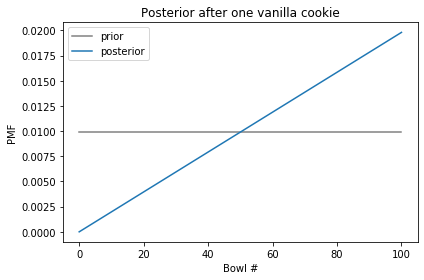

In [30]:
prior.plot(label='prior', color='gray')
posterior1.plot(label='posterior')
decorate_bowls('Posterior after one vanilla cookie')

Now suppose we put the cookie back, draw again from the same bowl, and get another vanilla cookie.
Here's the update after the second cookie:

In [31]:
posterior2 = posterior1 * likelihood_vanilla
posterior2.normalize()

0.6699999999999999

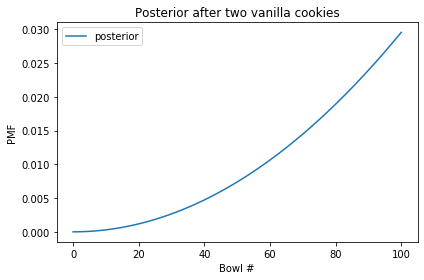

In [32]:
posterior2.plot(label='posterior')
decorate_bowls('Posterior after two vanilla cookies')

At this point the high-numbered bowls are the most likely because they contain the most vanilla cookies, and the low-numbered bowls have been all but eliminated.

But suppose we draw again and get a chocolate cookie.
Here's the update:

In [33]:
likelihood_chocolate = 1 - hypos/100

posterior3 = posterior2 * likelihood_chocolate
posterior3.normalize()

0.2462686567164179

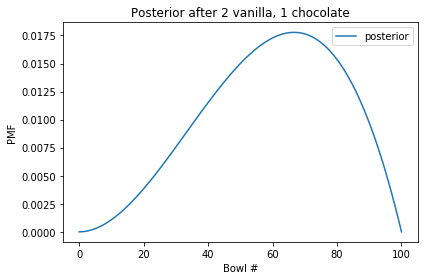

In [34]:
posterior3.plot(label='posterior')
decorate_bowls('Posterior after 2 vanilla, 1 chocolate')

The peak of the posterior distribution is at Bowl 67, which corresponds to the fraction of vanilla cookies in the data we've observed, $2/3$.

The quantity with the highest posterior probability is called the **MAP**.

To compute the MAP, we can use the `Series` method `idxmax`:

In [35]:
posterior3.idxmax()

67

Or `Pmf` provides a more memorable name for the same thing:

In [36]:
posterior3.max_prob()

67

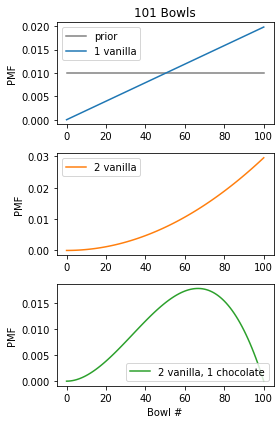

In [37]:
plt.figure(figsize=(4, 6))
plt.subplot(311)
prior.plot(label='prior', color='gray')
posterior1.plot(label='1 vanilla', color='C0')
plt.ylabel('PMF')
plt.title('101 Bowls')
plt.legend()

plt.subplot(312)
posterior2.plot(label='2 vanilla', color='C1')
plt.ylabel('PMF')
plt.legend()

plt.subplot(313)
posterior3.plot(label='2 vanilla, 1 chocolate', color='C2')
decorate_bowls('')

savefig('fig02-01')

## The dice problem

Suppose I have a box with a 6-sided die, an 8-sided die, and a 12-sided die.
I choose one of the dice at random, roll it, and report that the outcome is a 1.
What is the probability that I chose the 6-sided die?

I'll use integers to represent the hypotheses, and I can make the prior distribution like this:

In [38]:
hypos = [6, 8, 12]
prior = Pmf(1/3, hypos)
prior

,probs
6,0.333333
8,0.333333
12,0.333333


Now we can compute the likelihood of the data and use it to compute the posterior distribution.


In [39]:
likelihood1 = 1/6, 1/8, 1/12
posterior = prior * likelihood1
posterior.normalize()
posterior

,probs
6,0.444444
8,0.333333
12,0.222222


In [40]:
write_pmf(posterior, 'table02-02')

One note about the `Pmf` class: if you multiply a `Pmf` by a sequence, the result is a `Pmf`:

In [41]:
type(prior * likelihood1)

empiricaldist.empiricaldist.Pmf

If you do it the other way around, the result is a `Series`:

In [42]:
type(likelihood1 * prior)

pandas.core.series.Series

But you can use `Pmf` to convert it back to a `Pmf`:

In [43]:
Pmf(likelihood1 * prior)

,probs
6,0.055556
8,0.041667
12,0.027778


Now suppose I roll the same die again and get a $7$.
We can do a second update like this:

In [44]:
likelihood2 = 0, 1/8, 1/12
posterior *= likelihood2
posterior.normalize()
posterior

,probs
6,0.000000
8,0.692308
12,0.307692


In [45]:
write_pmf(posterior, 'table02-03')

## Updating dice

The following function is a more general version of the update in the previous section:

In [46]:
def update_dice(pmf, data):
    """Update a pmf based on new data.
    
    pmf: Pmf of possible dice and their probabilities
    data: integer outcome
    """
    hypos = pmf.qs
    likelihood = 1 / hypos
    impossible = (data > hypos)
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()

Here's how we can use this function to compute the updates in the previous section:

In [47]:
pmf = prior.copy()
pmf

,probs
6,0.333333
8,0.333333
12,0.333333


In [48]:
update_dice(pmf, 1)
update_dice(pmf, 7)
pmf

,probs
6,0.000000
8,0.692308
12,0.307692


## Exercises

**Exercise:** Suppose I have a box with a 6-sided die, an 8-sided die, and a 12-sided die.
I choose one of the dice at random, roll it four times, and get 1, 3, 5, and 7.
What is the probability that I chose the 8-sided die?

In [49]:
# Solution

pmf = prior.copy()
for data in [1, 3, 5, 7]:
    update_dice(pmf, data)
    
pmf

,probs
6,0.000000
8,0.835052
12,0.164948


**Exercise:** In the previous version of the dice problem, the prior probabilities are the same because the box contains one of each die.
But suppose the box contains 1 die that is 4-sided, 2 dice that are 6-sided, 3 dice that are 8-sided, 4 dice that are 12-sided, and 5 dice that are 20-sided.
I choose a die, roll it, and get a 7.  
What is the probability that I chose an 8-sided die?

In [55]:
# Solution

ps = [1,2,3,4,5]
qs = [4,6,8,12,20]
pmf = Pmf(ps, qs)
update_dice(pmf, 7)
pmf

,probs
4,0.000000
6,0.000000
8,0.391304
12,0.347826
20,0.260870


**Exercise:** Suppose I have two sock drawers.  
One contains equal numbers of black and white socks.  
The other contains equal numbers of red, green, and blue socks.
Suppose I choose a drawer and random, choose two socks at random, and I tell you that I got a matching pair.
What is the probability that the socks are white?

For simplicity, let's assume that there are so many socks in both drawers that removing one sock makes a negligible change to the proportions.

In [51]:
# Solution

# In the BlackWhite drawer, the probability of getting a match is 1/2
# In the RedGreenBlue drawer, the probability of a match is 1/3

hypos = ['BlackWhite', 'RedGreenBlue']
prior = Pmf(1/2, hypos)
likelihood = 1/2, 1/3
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
BlackWhite,0.6
RedGreenBlue,0.4


In [52]:
# Solution

# If I drew from the BlackWhite drawer, the probability the
# socks are white is 1/2

posterior['BlackWhite'] / 2

0.30000000000000004

**Exercise:** Here's a problem from [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/):

> Elvis Presley had a twin brother (who died at birth). What is the probability that Elvis was an identical twin?

Hint: In 1935, about 2/3 of twins were fraternal and 1/3 were identical.

In [53]:
# Solution

# The trick to this question is to notice that Elvis's twin was a brother.
# If they were identical twins, it is certain they would be the same sex.
# If they were fraternal twins, the likelihood is only 50%.

table = pd.DataFrame(index=['identical', 'fraternal'])
table['prior'] = 1/3, 2/3
table['likelihood'] = 1, 1/2

table['unnorm'] = table['prior'] * table['likelihood']
prob_data = table['unnorm'].sum()

table['posterior'] = table['unnorm'] / prob_data
table

,prior,likelihood,unnorm,posterior
identical,0.333333,1.0,0.333333,0.5
fraternal,0.666667,0.5,0.333333,0.5


In [54]:
# Solution

hypos = ['identical', 'fraternal']
prior = Pmf([1/3, 2/3], hypos)
likelihood = 1, 1/2
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
identical,0.5
fraternal,0.5
